In [3]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate
from icecream import ic

In [4]:
INSTANCES = [
    {"UNIVERSE_SIZE": 100, "NUM_SETS": 10, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 1000, "NUM_SETS": 100, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 10_000, "NUM_SETS": 1_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.1},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.2},
    {"UNIVERSE_SIZE": 100_000, "NUM_SETS": 10_000, "DENSITY": 0.3}
]

In [5]:
def generate_instance(universe_size, num_sets, density):
    rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
    sets = rng.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(sets[:, s]):
            sets[rng.integers(num_sets), s] = True
    costs = np.power(sets.sum(axis=1), 1.1)
    return sets, costs

In [6]:
def valid(solution, sets):
    phenotype = np.logical_or.reduce(sets[solution])
    return np.all(phenotype)

def cost(solution, costs):
    return costs[solution].sum()

In [7]:
def fitness(solution, sets, costs):
    return (valid(solution, sets), -cost(solution, costs))

In [8]:
def tweak(solution, num_sets, rng):
    new_solution = solution.copy()
    i = rng.integers(0, num_sets)
    new_solution[i] = not new_solution[i]
    return new_solution

def multiple_mutation(solution, num_sets, rng):
    mask = rng.random(num_sets) < 0.01
    new_solution = np.logical_xor(solution, mask)
    return new_solution

In [9]:
rng = np.random.Generator(np.random.PCG64())

## Steepest Step and Restart


In [8]:
def solve_instance(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    
    best_solution = solution.copy()
    best_fitness = solution_fitness
    history = [solution_fitness[1]]
    
    iterations_without_improvement = 0
    max_iterations_without_improvement = 1000
    
    for _ in range(max_iterations):
        if iterations_without_improvement < max_iterations_without_improvement:
            new_solution = tweak(solution, instance["NUM_SETS"], rng)
        else:
            new_solution = multiple_mutation(solution, instance["NUM_SETS"], rng)
        
        new_fitness = fitness(new_solution, sets, costs)
        history.append(new_fitness[1])
        
        if new_fitness > solution_fitness:
            solution = new_solution
            solution_fitness = new_fitness 
            iterations_without_improvement = 0
            
            if solution_fitness > best_fitness:
                best_solution = solution.copy()
                best_fitness = solution_fitness
        else:
            iterations_without_improvement += 1
    
    return best_solution, best_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-284.0492127923681))
Instance 2 - Best fitness: (np.True_, np.float64(-6907.841433603412))
Instance 3 - Best fitness: (np.True_, np.float64(-128362.88573966175))
Instance 4 - Best fitness: (np.True_, np.float64(-92826836.20773539))
Instance 5 - Best fitness: (np.True_, np.float64(-197461543.20992807))
Instance 6 - Best fitness: (np.True_, np.float64(-312149879.43748105))


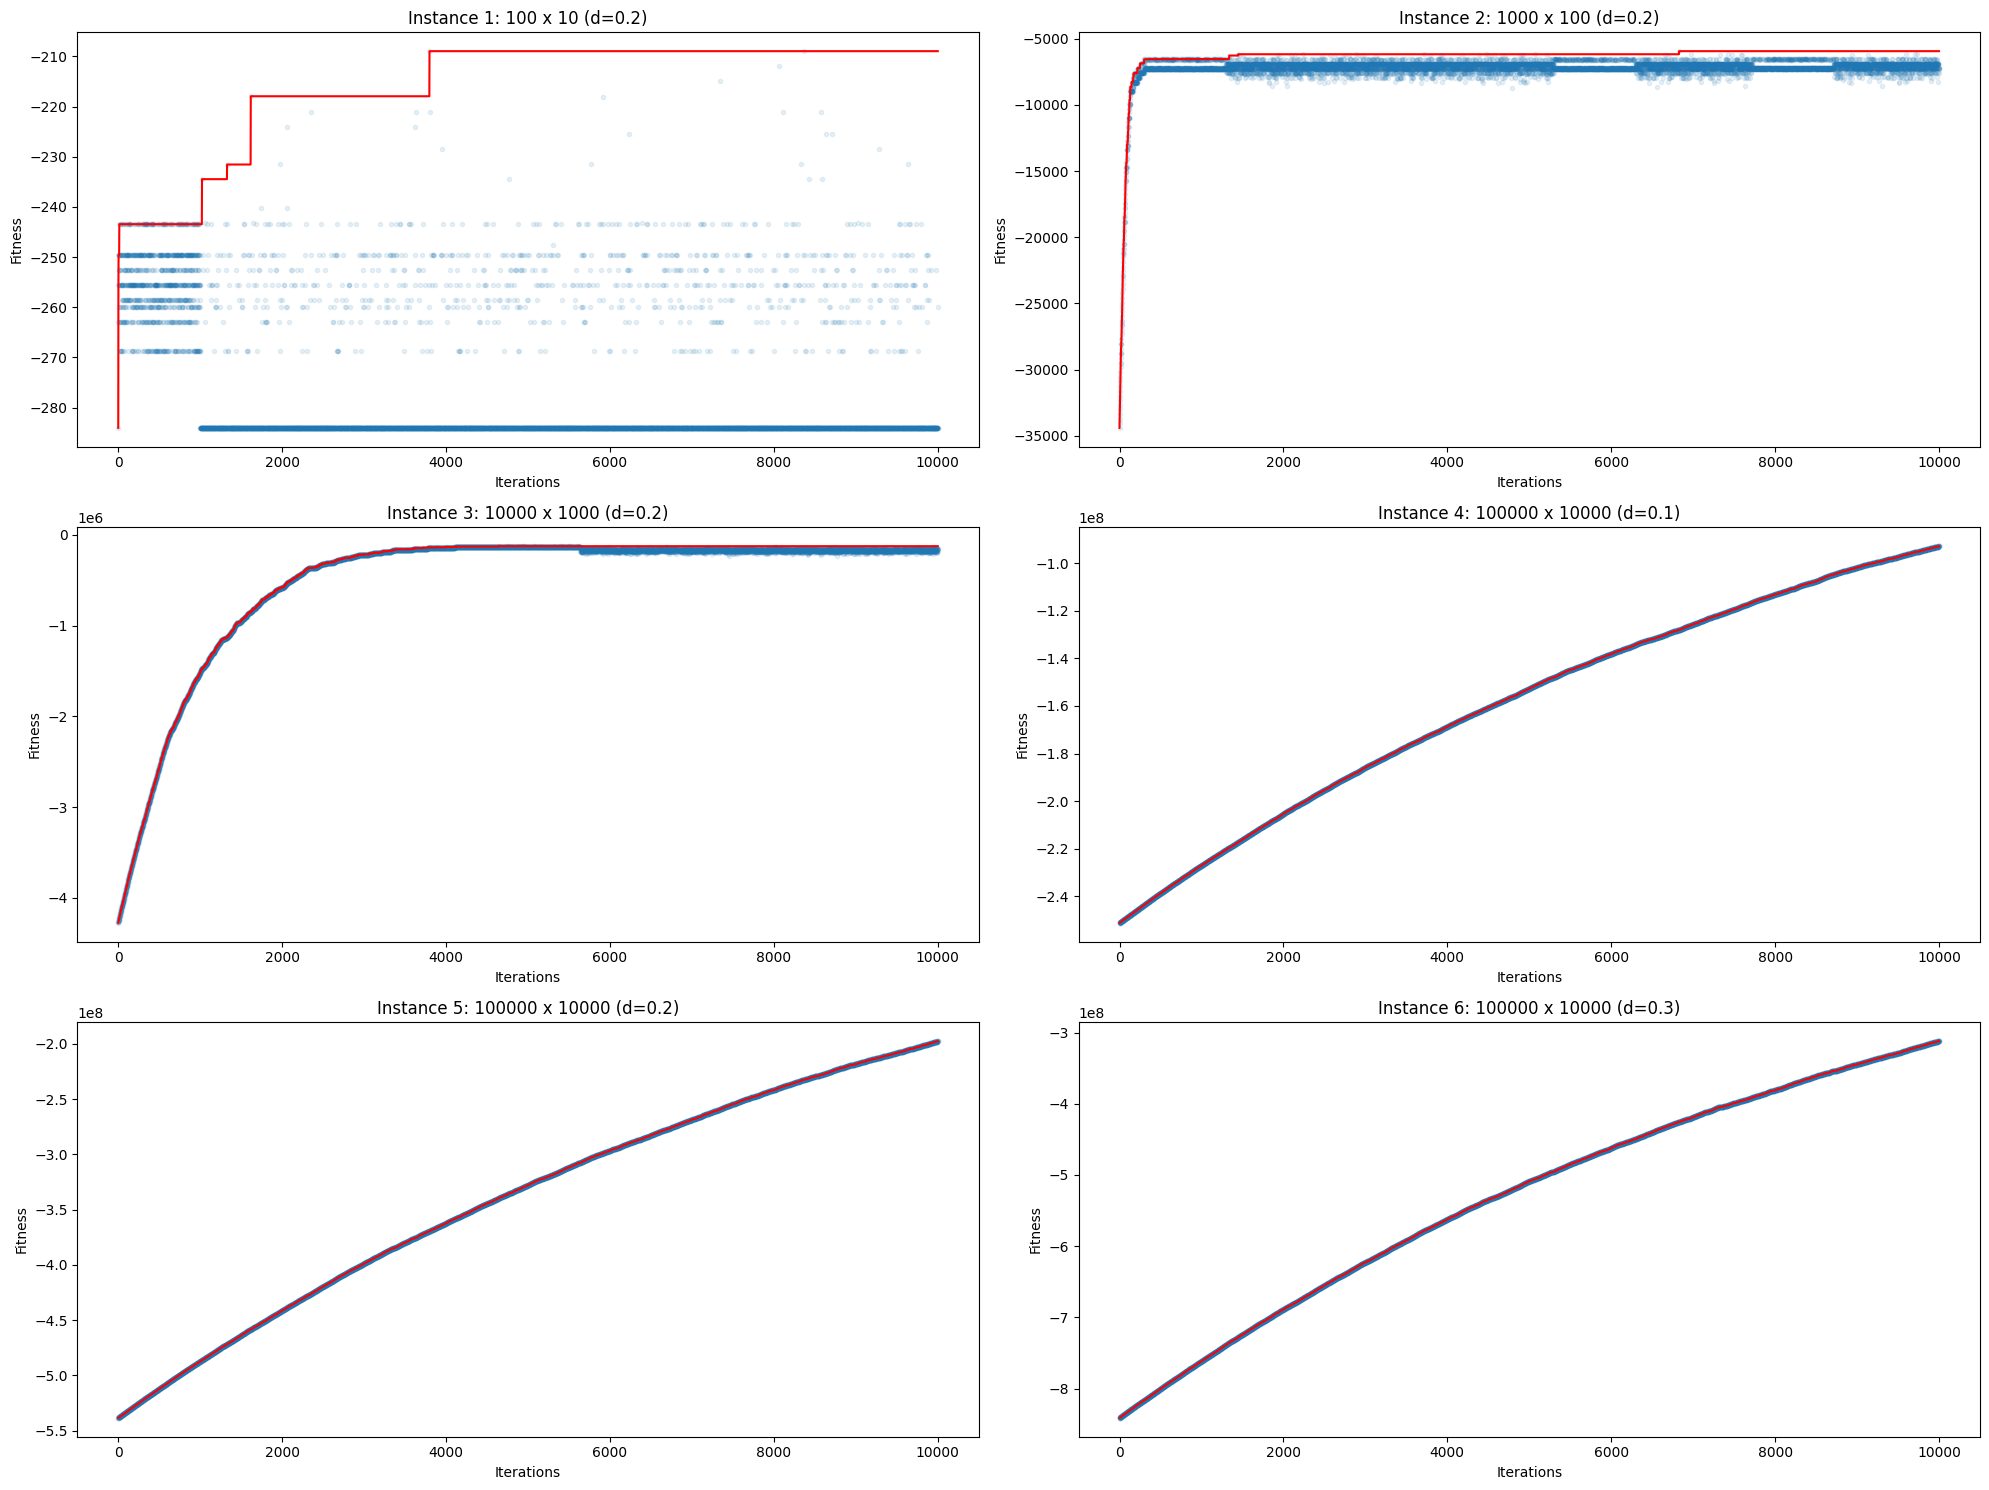

In [9]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


## Hill climber

In [10]:
def solve_instance_hc(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    history = [solution_fitness[1]]
    
    for _ in range(max_iterations):
        new_solution = tweak(solution, instance["NUM_SETS"], rng)
        f=fitness(new_solution, sets, costs)
        history.append(f[1])
        if f > solution_fitness:
            solution=new_solution
            solution_fitness=fitness(solution,sets, costs)
    
    return solution, solution_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-284.0492127923681))
Instance 2 - Best fitness: (np.True_, np.float64(-7610.819213981475))
Instance 3 - Best fitness: (np.True_, np.float64(-128158.8276018862))
Instance 4 - Best fitness: (np.True_, np.float64(-93345652.7262584))
Instance 5 - Best fitness: (np.True_, np.float64(-195047772.5736515))
Instance 6 - Best fitness: (np.True_, np.float64(-309502124.05509394))


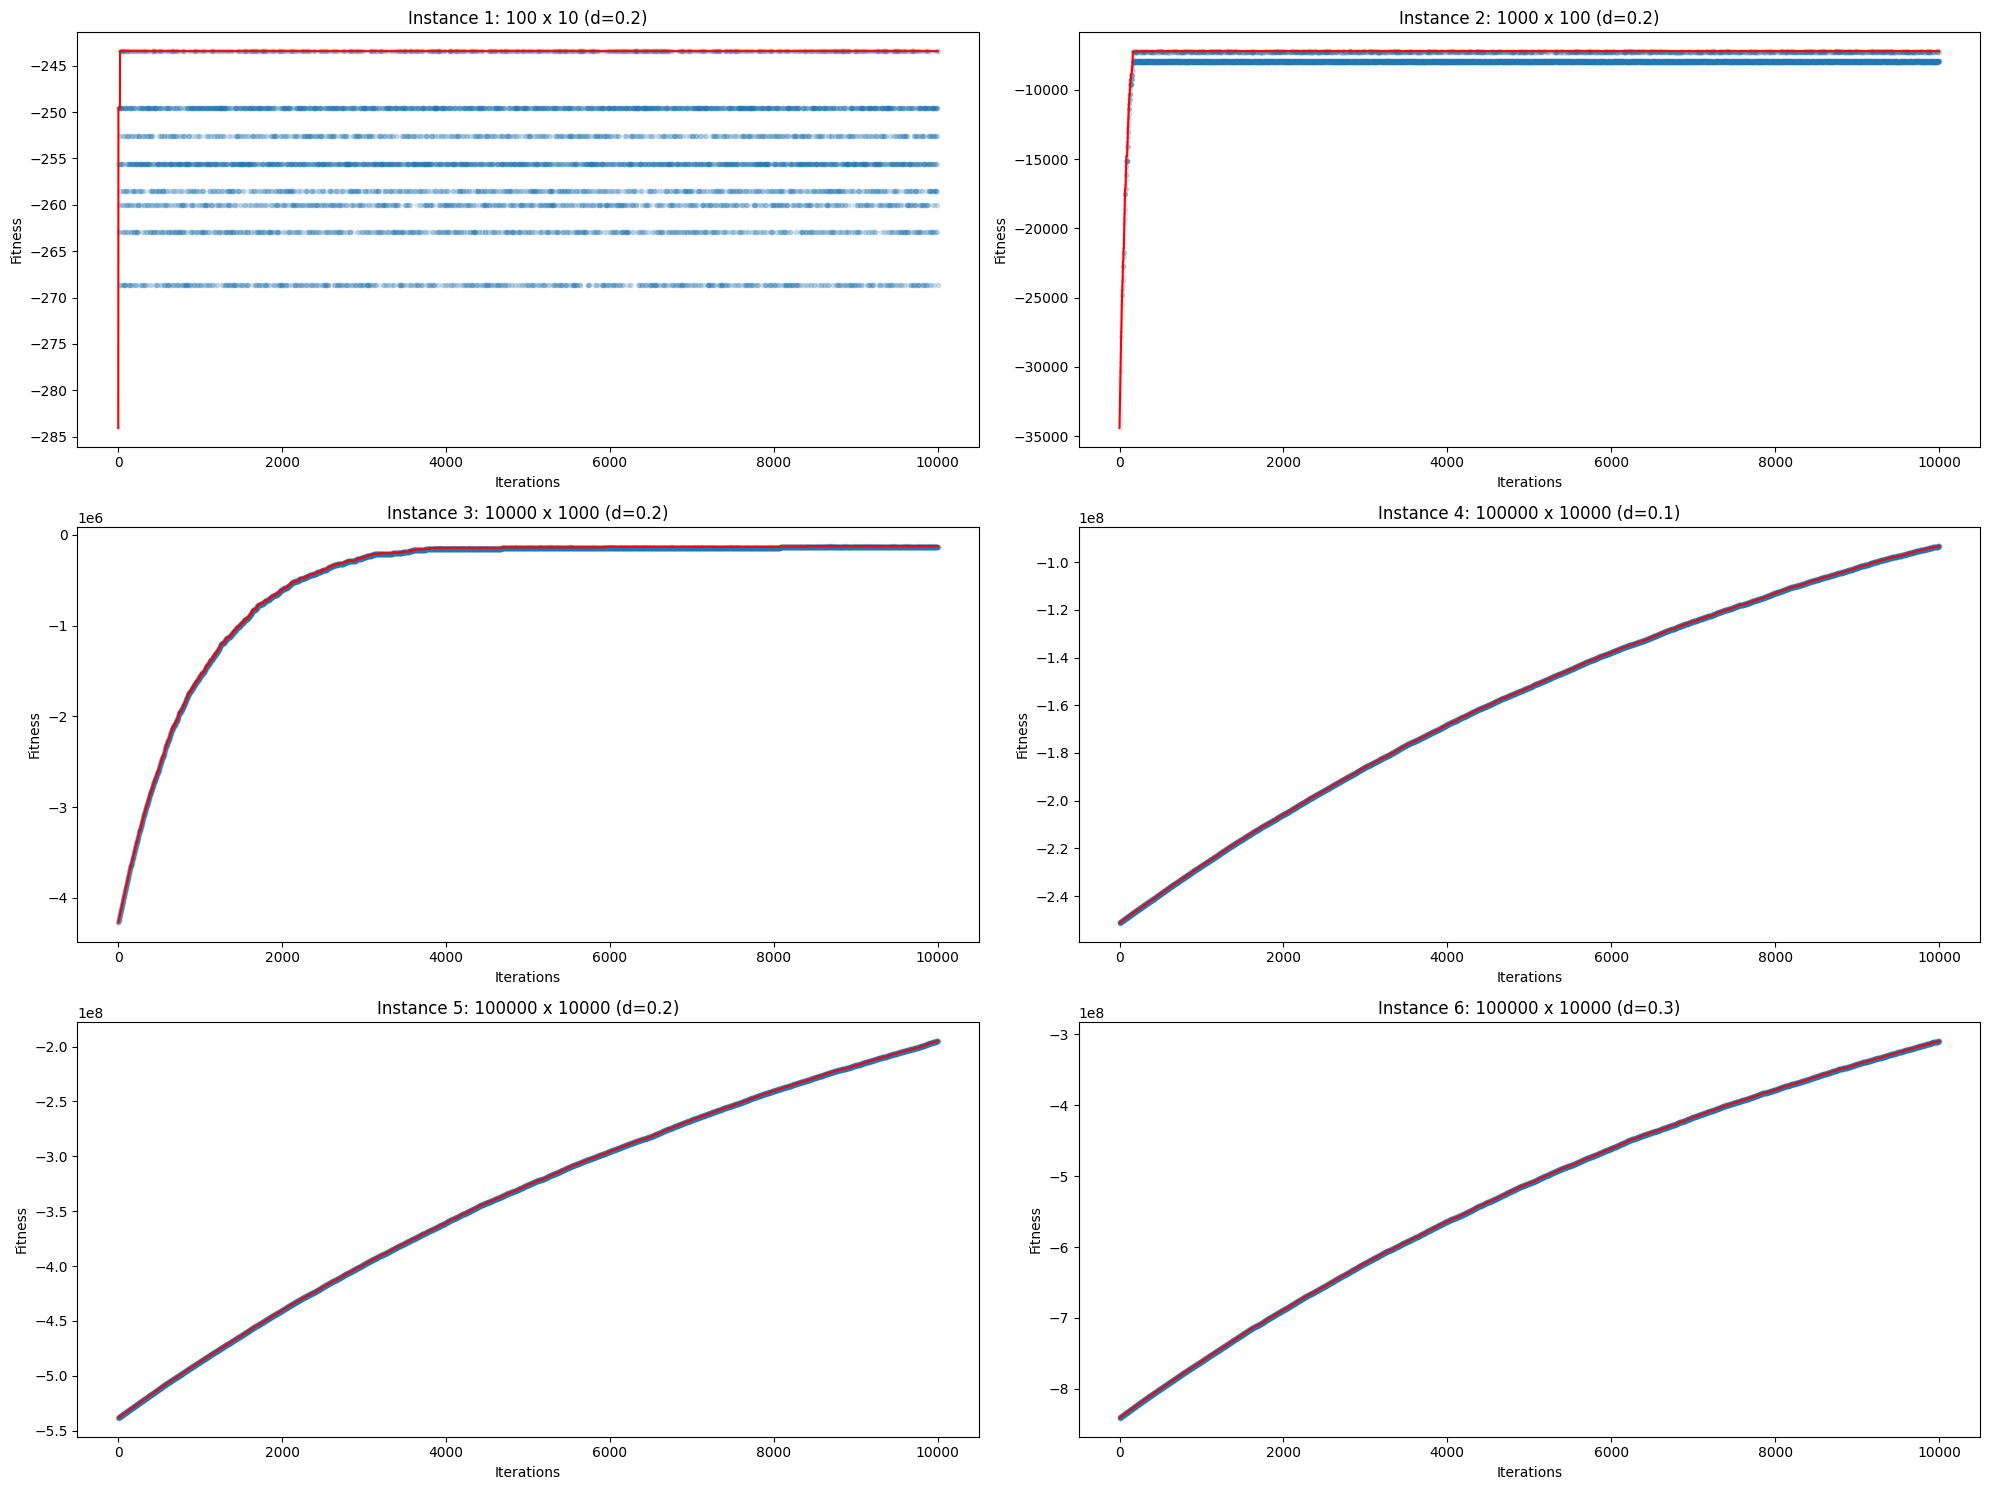

In [11]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance_hc(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


# Simple RHCM

In [14]:
def solve_instance_rhcm(instance, max_iterations=10_000):
    sets, costs = generate_instance(instance["UNIVERSE_SIZE"], instance["NUM_SETS"], instance["DENSITY"])
    
    solution = rng.random(instance["NUM_SETS"]) < 1
    solution_fitness = fitness(solution, sets, costs)
    history = [solution_fitness[1]]
    
    for _ in range(max_iterations):
        new_solution = multiple_mutation(solution, instance["NUM_SETS"], rng)
        f=fitness(new_solution, sets, costs)
        history.append(f[1])
        if f > solution_fitness:
            solution=new_solution
            solution_fitness=fitness(solution,sets, costs)
    
    return solution, solution_fitness, history

Instance 1 - Best fitness: (np.True_, np.float64(-284.0492127923681))
Instance 2 - Best fitness: (np.True_, np.float64(-6689.048039396116))
Instance 3 - Best fitness: (np.True_, np.float64(-593915.1166527013))
Instance 4 - Best fitness: (np.True_, np.float64(-93988492.31908943))
Instance 5 - Best fitness: (np.True_, np.float64(-201017862.11439574))
Instance 6 - Best fitness: (np.True_, np.float64(-313966659.86596954))


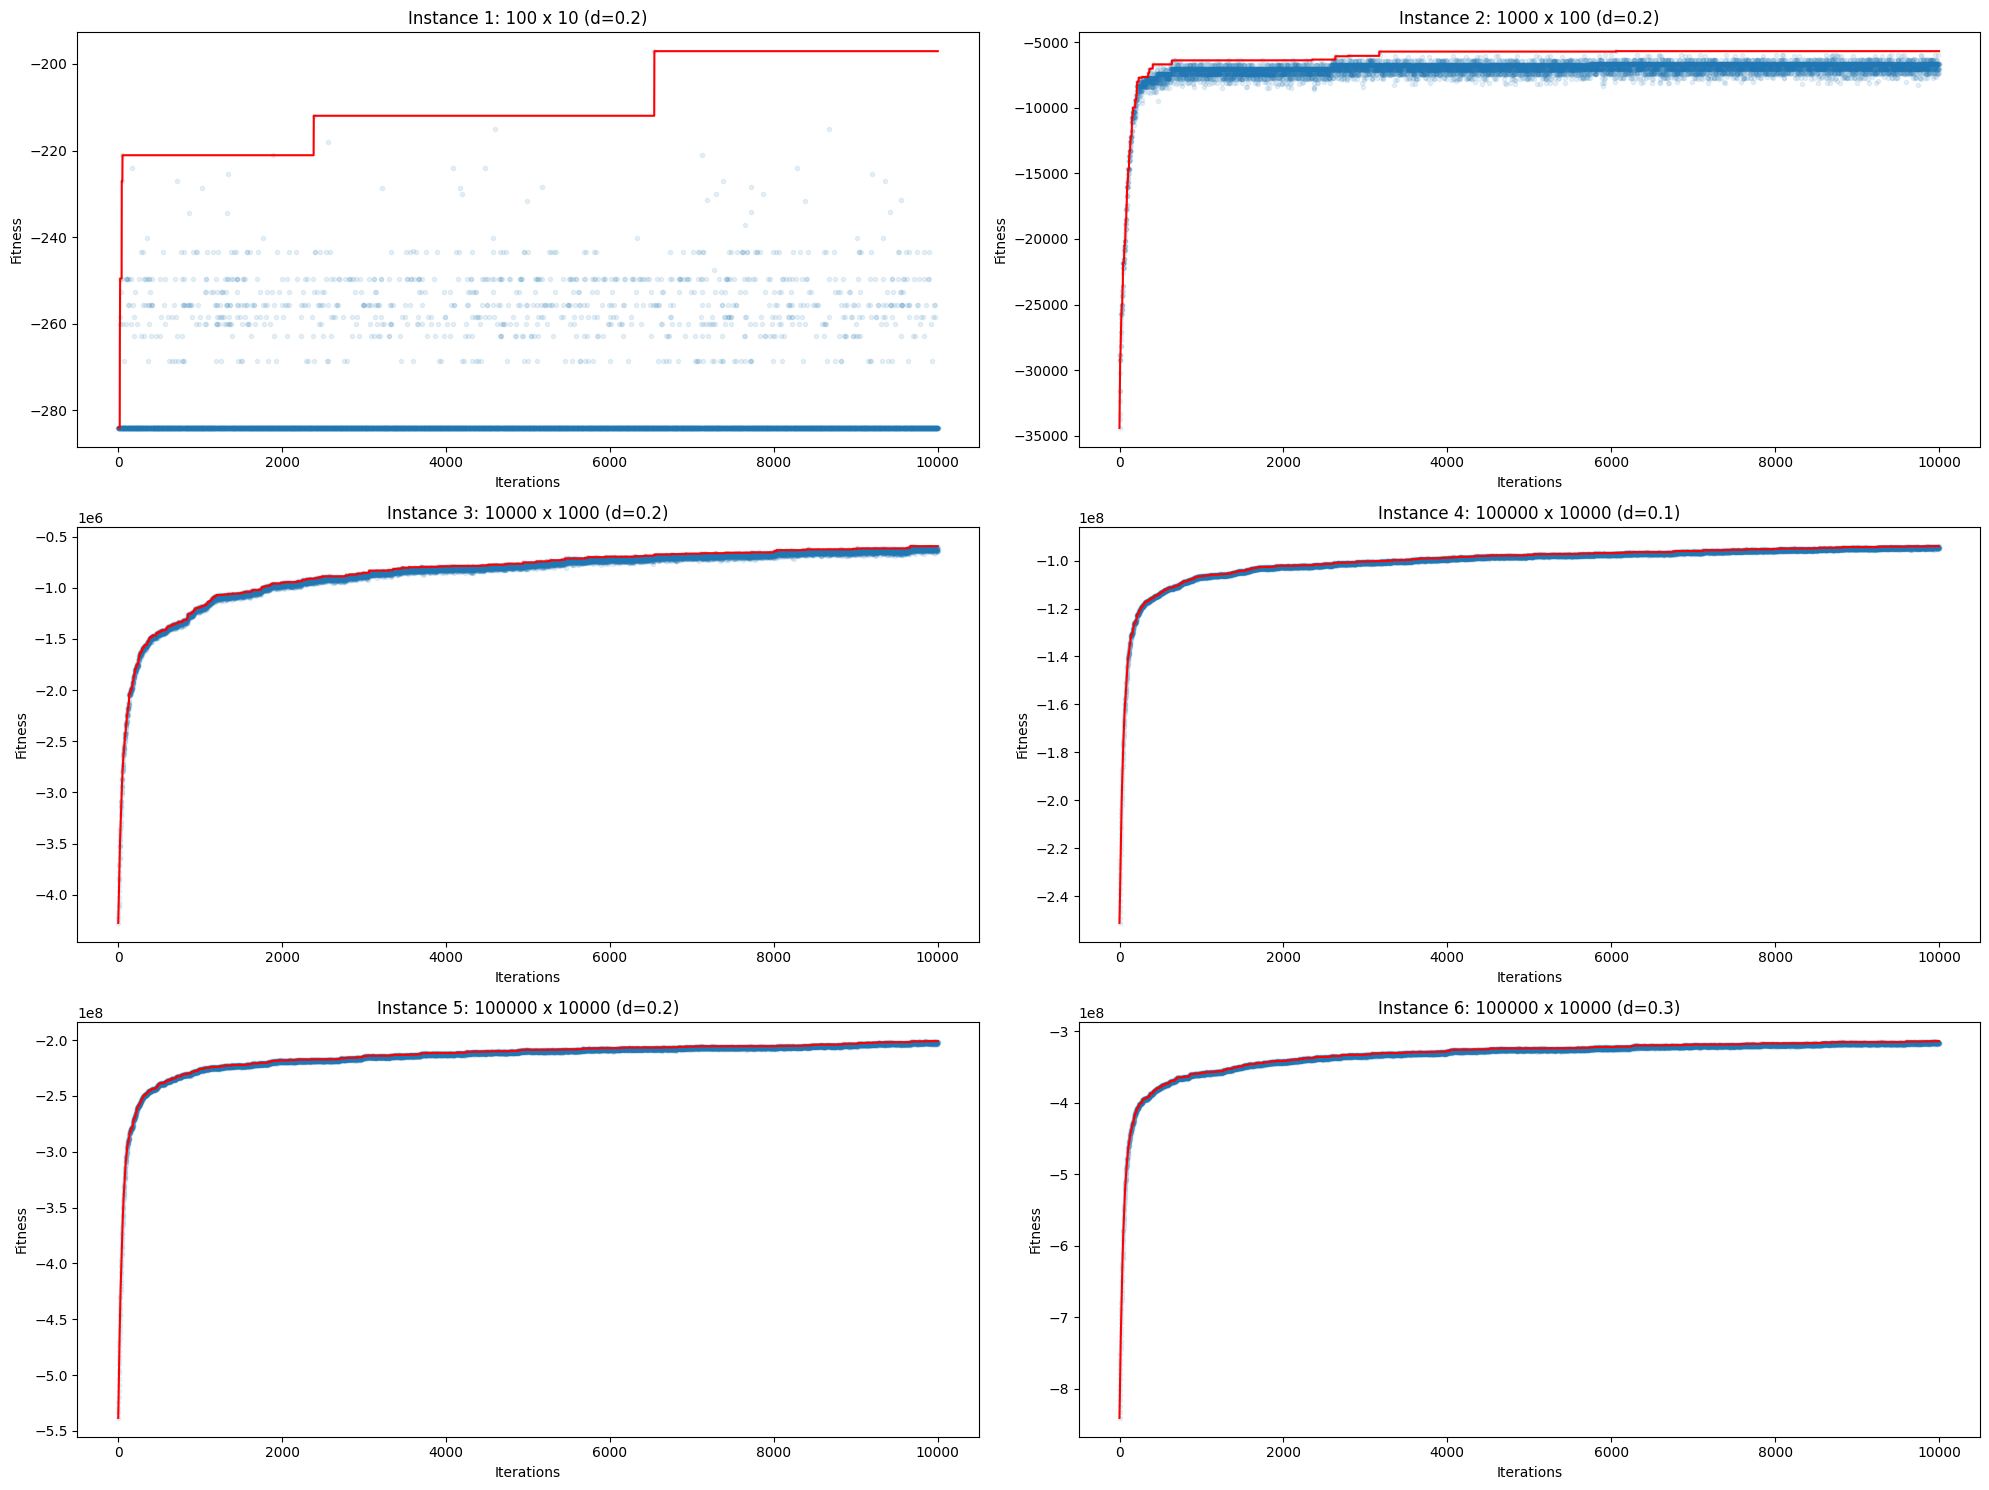

In [15]:
plt.figure(figsize=(20, 15))

for idx, instance in enumerate(INSTANCES, 1):
    solution, fitness_value, history = solve_instance_rhcm(instance)
    
    plt.subplot(3, 2, idx)
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".", alpha=0.1)
    plt.title(f"Instance {idx}: {instance['UNIVERSE_SIZE']} x {instance['NUM_SETS']} (d={instance['DENSITY']})")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    
    print(f"Instance {idx} - Best fitness: {fitness_value}")

plt.tight_layout()
plt.show()


From the results obtained it seems that the Steepest Step and Restart strategy produced the best results,especially for large instances.Despite that it is evident from the graph that the behavior of the Steepest Step and Restart and the hill climber for such instances is purely similar, suggesting that with only 10000 iterations it is difficult to arrive at a local maximum in the fittnes function